In [1]:
# Import necessary libraries

import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit.circuit import ParameterVector
from qiskit_aer import AerSimulator

simulator = AerSimulator()

In [2]:
# Define screen range and number of qubits to represent it

π = np.pi
scrn_range = 6*π
scrn_qbs = 8
φ_arr = ParameterVector('φ',scrn_qbs)

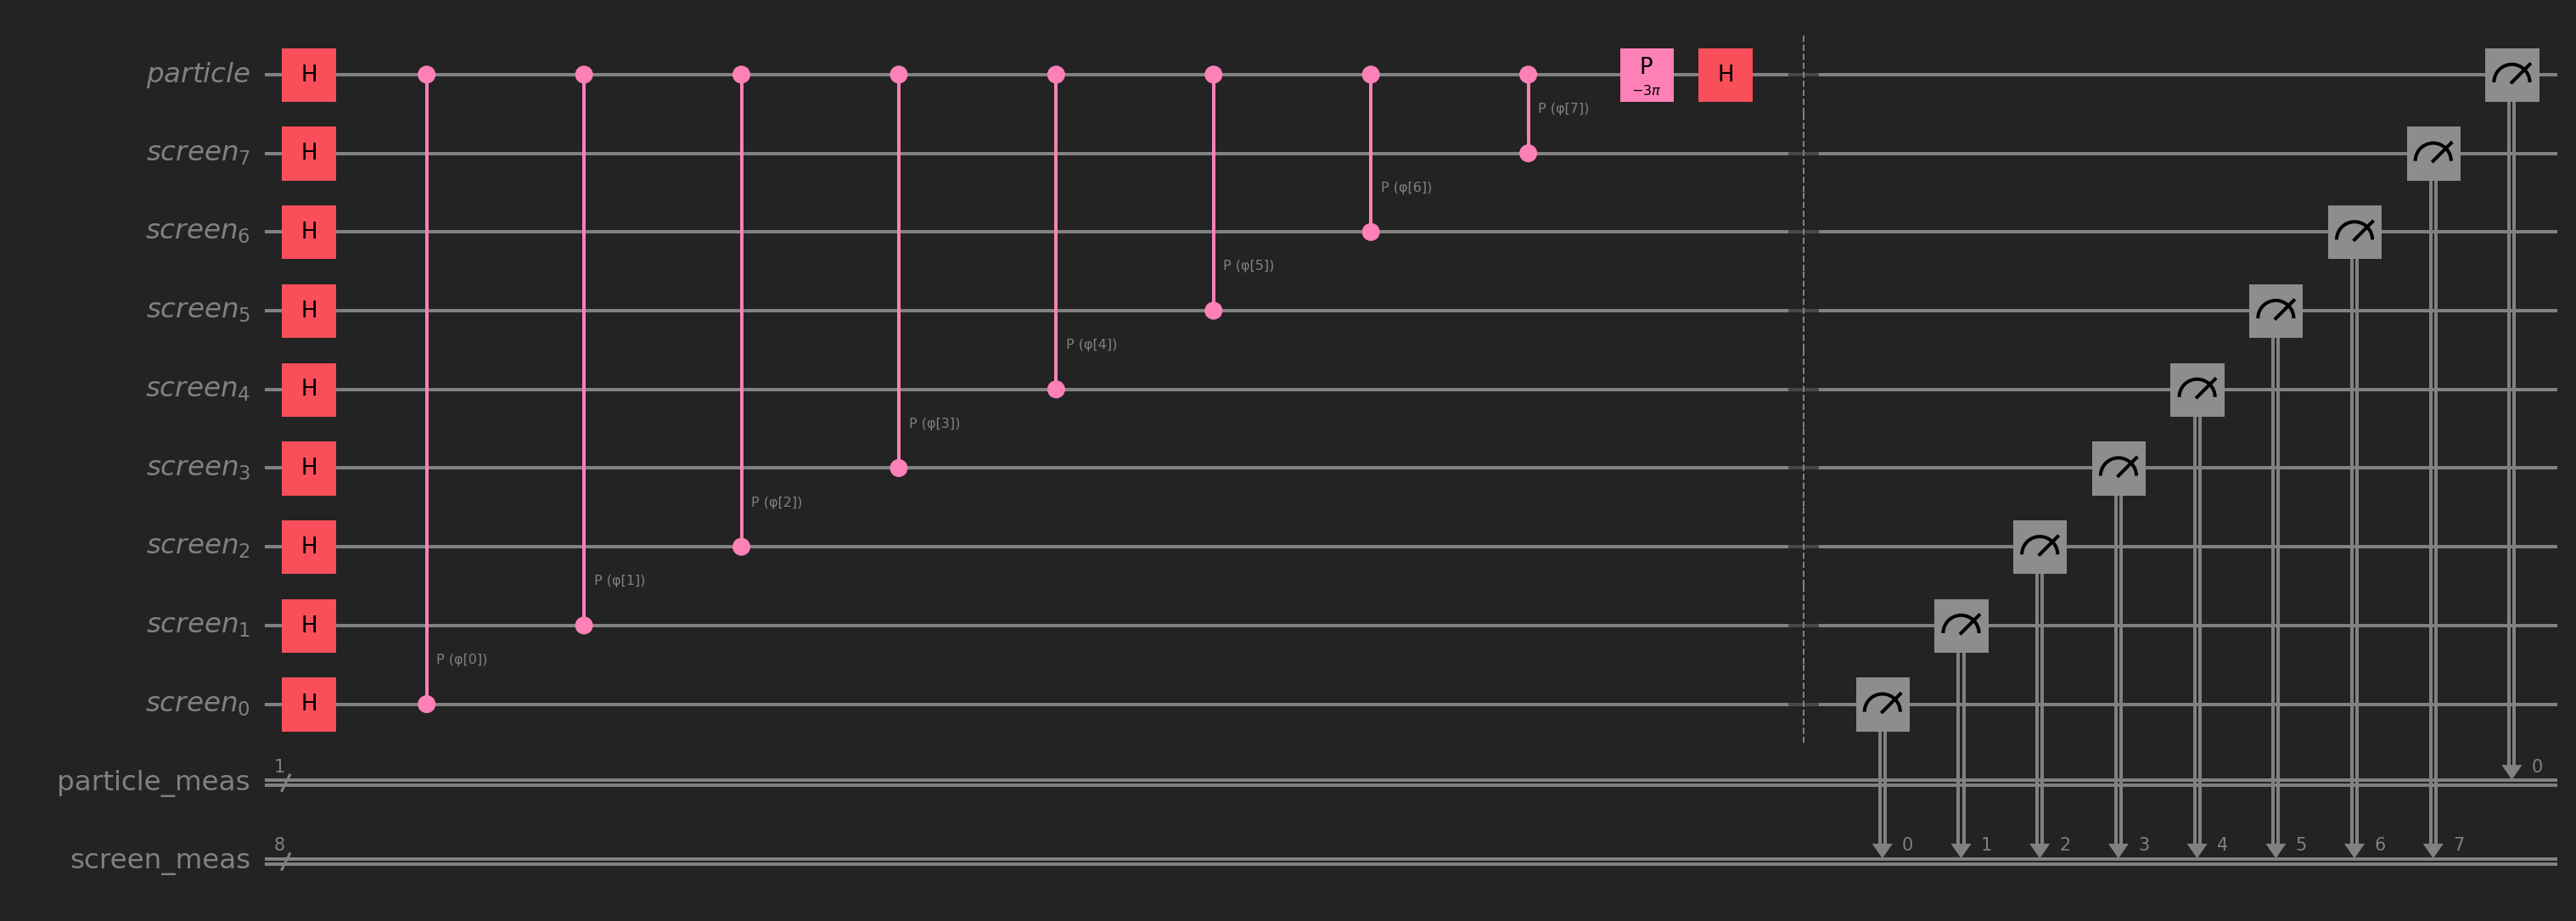

In [3]:
# define quantum circuit equivalent to double-slit experiment including screen qubits

qr_part = QuantumRegister(1, name='particle')
qr_scrn = QuantumRegister(scrn_qbs, name='screen')
cr_part = ClassicalRegister(1,'particle_meas')
cr_scrn = ClassicalRegister(scrn_qbs,'screen_meas')

qc = QuantumCircuit(qr_scrn,qr_part,cr_scrn,cr_part)
qc.h(qr_part)
qc.h(qr_scrn)

for qb, φ in enumerate(φ_arr):
    qc.cp(φ,qr_scrn[qb],qr_part)
    
qc.p(-scrn_range/2,qr_part)
qc.h(qr_part)
qc.barrier()

qc.measure(qr_scrn,cr_scrn)
qc.measure(qr_part,cr_part)
qc.draw(fold = -1)

In [4]:
# transpile to circuit that can be ran by simulator

qc_trans = transpile(qc, backend=simulator)

In [5]:
# define incremental value of φ, and list of angles to apply to controlled-phase gates

φ_step = scrn_range/(2**scrn_qbs)
φ_vals = [(2**(qb))*φ_step for qb in range(scrn_qbs)]

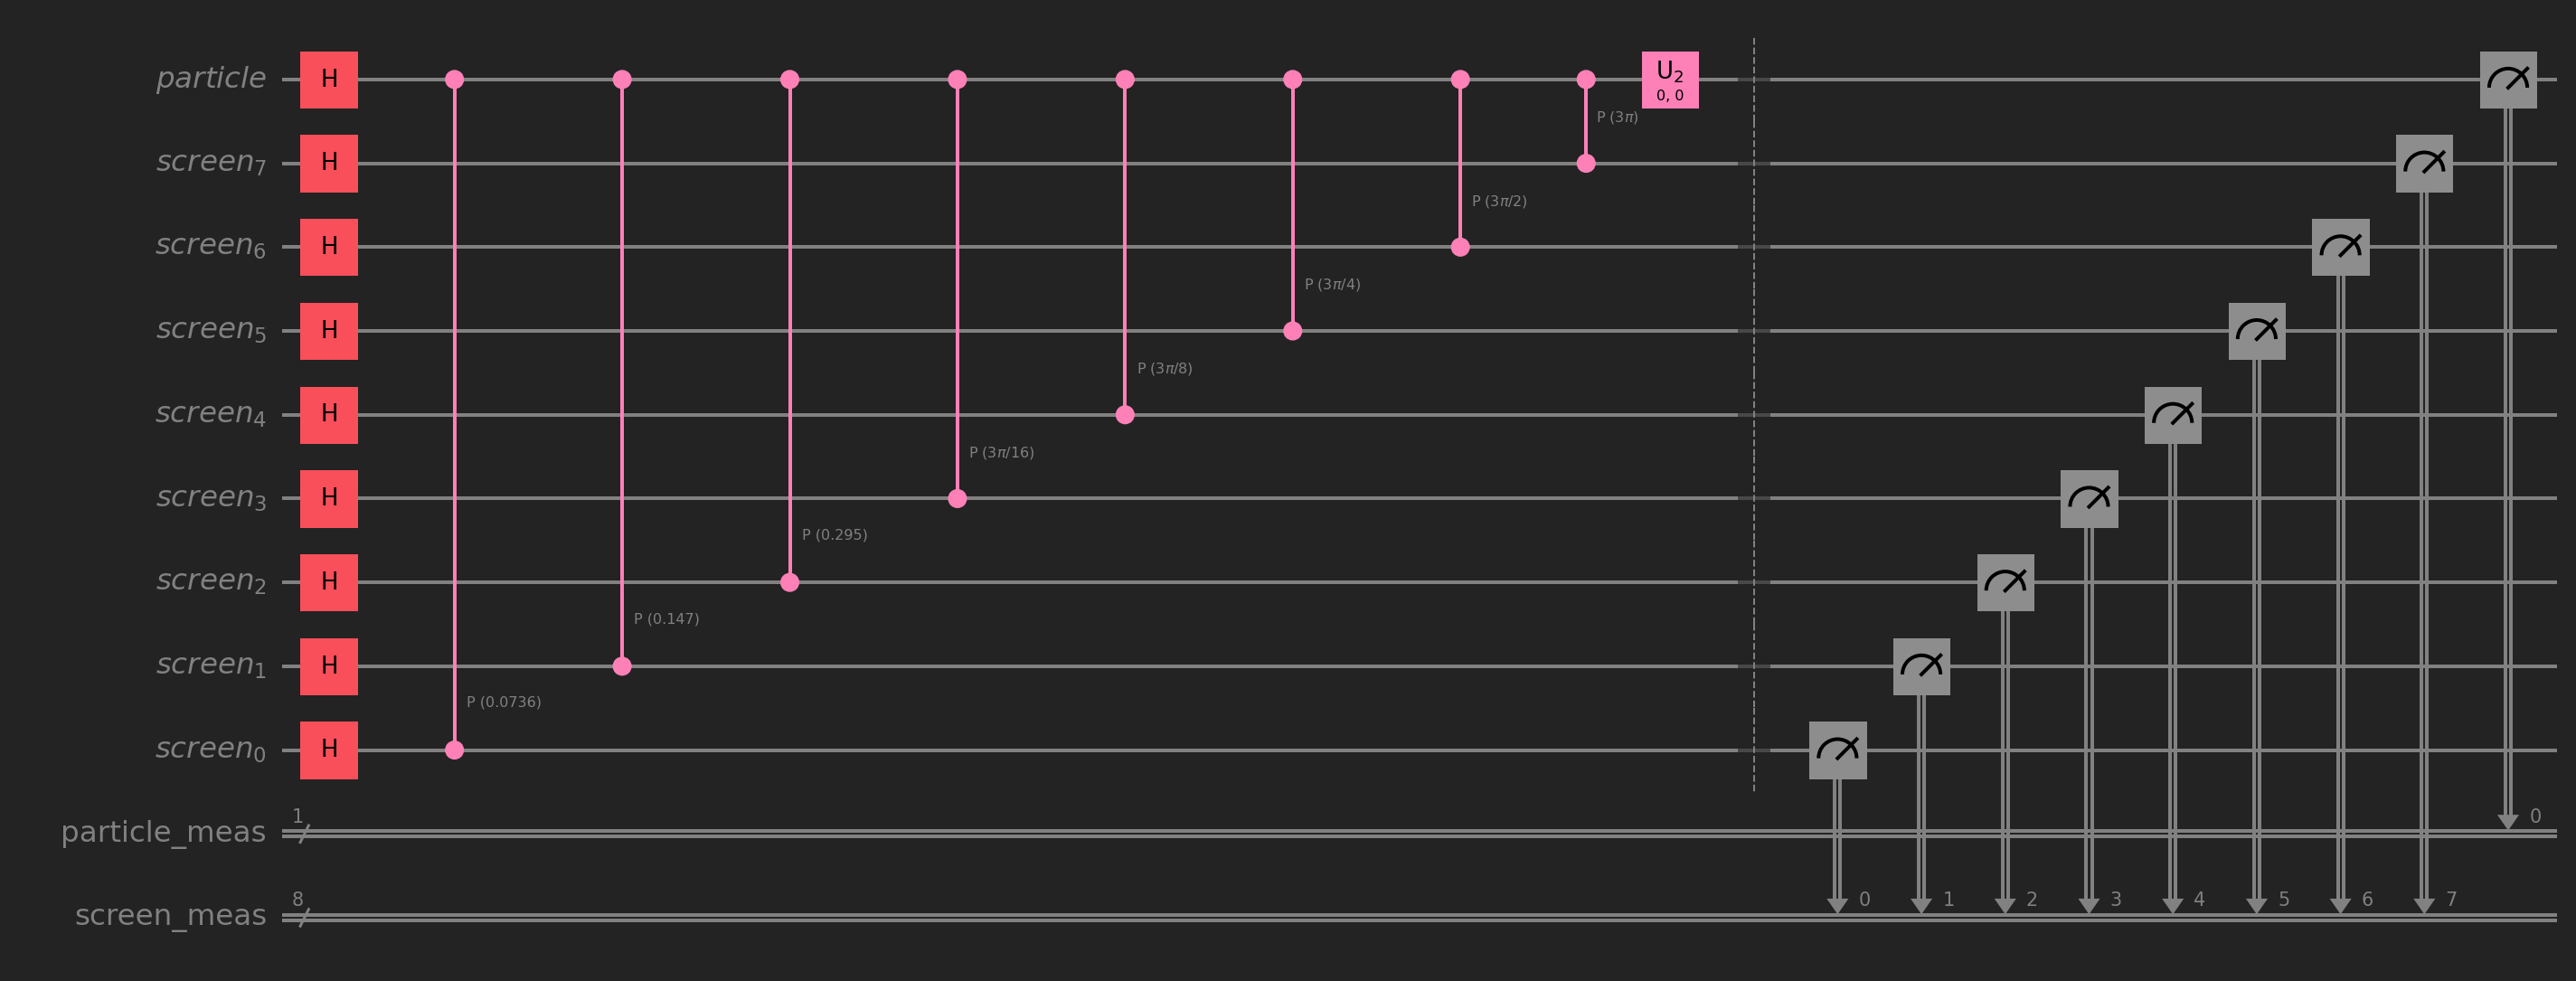

In [6]:
# Assign angle values to parameterized circuit

qc_sim = qc_trans.assign_parameters({φ_arr:φ_vals})
qc_sim.draw(fold=-1)

In [7]:
# Execute simulation

shots = 8196
job = simulator.run(qc_sim, shots=shots)
sim_results = job.result()
sim_counts = sim_results.get_counts()

In [8]:
# Post-process results: select values of φ where we measured a 0 (i.e., particle hit the screen)

φ_hit = []

for res_str, res_counts in sim_counts.items():
    if res_str[0] == '0':
        φ_val = 0
        for i, bit in enumerate(reversed(res_str[2:])):
            φ_val += int(bit)*φ_vals[i]
        
        φ_val -= scrn_range/2
        φ_hit += res_counts*[φ_val]

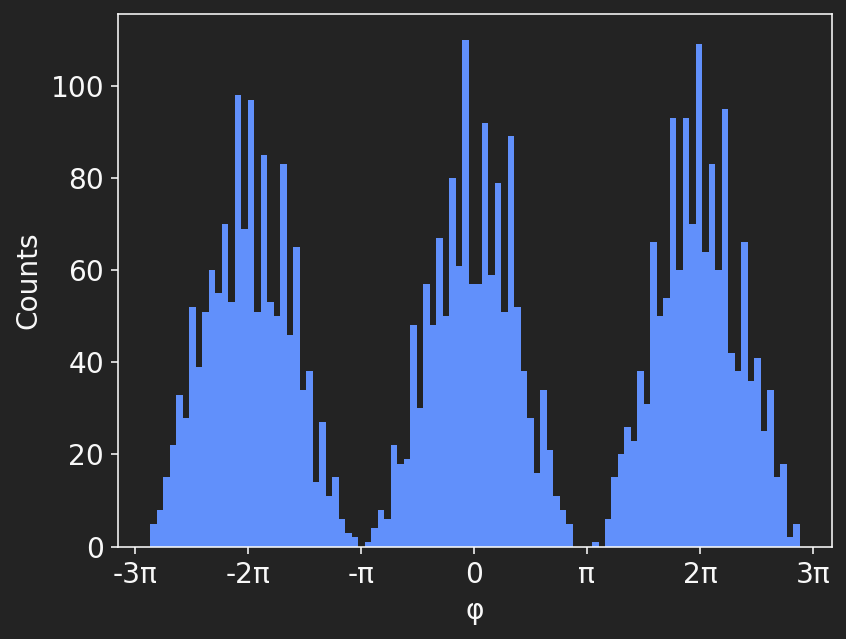

In [9]:
# Plot distribution of values φ where we measured a 0 (i.e., particle hit the screen)

ax = plt.subplot()
plt.hist(φ_hit, bins=100, color='#6190fb')
plt.xticks(ticks=[-3*π, -2*π, -π, 0, π, 2*π, 3*π],
           labels=['-3π','-2π','-π','0','π','2π','3π'],
           fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('φ', fontsize=14)
plt.ylabel('Counts',fontsize=14)
plt.grid(axis='y',linestyle='dashed')
ax.set_axisbelow(True)
plt.show()

In [10]:
z_hit = np.random.uniform(-1,1,len(φ_hit))

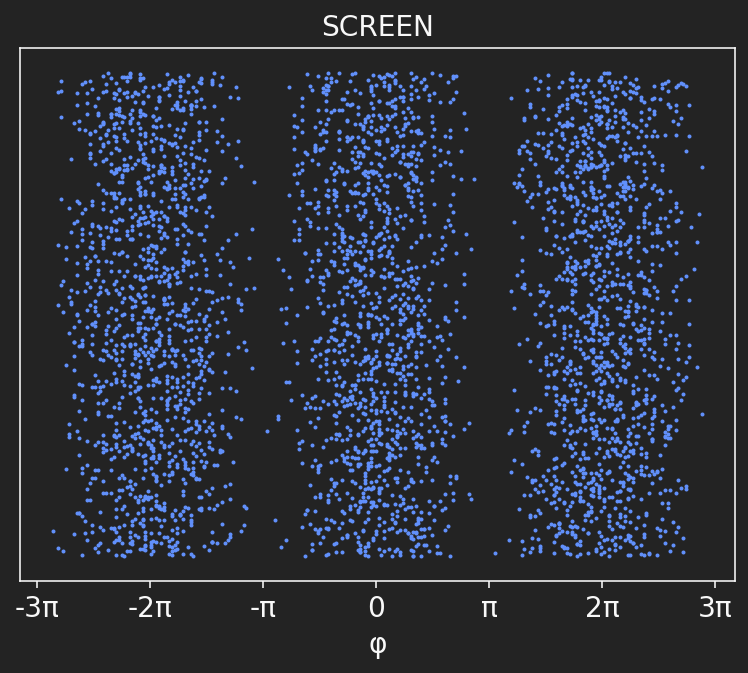

In [11]:
# Emulate hits on a screen. Values of z coordinate are selected at random

plt.scatter(φ_hit,z_hit, s = 1, color='#6190fb')
plt.tick_params(axis='both', left=False, labelleft=False)
plt.xticks(ticks=[-3*π, -2*π, -π, 0, π, 2*π, 3*π],
           labels=['-3π','-2π','-π','0','π','2π','3π'],
           fontsize=14)
plt.xlabel('φ', fontsize=14)
plt.title('SCREEN', fontsize=14)
plt.show()

In [12]:
# Import functions necessary to execute experiment in real QPU

from qiskit_ibm_provider import IBMProvider, least_busy
from qiskit_ibm_provider.job import job_monitor

In [13]:
# Select QPU

provider = IBMProvider()
qpu = provider.get_backend('ibm_brisbane')
print(qpu.name)

ibm_brisbane


In [14]:
# transpile to circuit that can be ran by simulator

qc_trans = transpile(qc, backend=qpu)

In [15]:
qc_qpu = qc_trans.assign_parameters({φ_arr:φ_vals})
qc_qpu.draw(fold=-1)

In [16]:
# Run circuit on QPU

job = qpu.run(qc_qpu, shots=shots)
job_id = job.job_id()
print(job_id)

cmvd7rqvpdgg008ge9pg


In [17]:
# Check status of execution

retrieve_job = provider.retrieve_job(job_id)
retrieve_job.status()

<JobStatus.QUEUED: 'job is queued'>

In [22]:
# Extract results

qpu_results = job.result()
qpu_counts = qpu_results.get_counts()

In [24]:
# Post-process results: select values of φ where we measured a 0 (i.e., particle hit the screen)

φ_hit = []

for res_str, res_counts in qpu_counts.items():
    if res_str[0] == '0':
        φ_val = 0
        for i, bit in enumerate(reversed(res_str[2:])):
            φ_val += int(bit)*φ_vals[i]
        
        φ_val -= scrn_range/2
        φ_hit += res_counts*[φ_val]

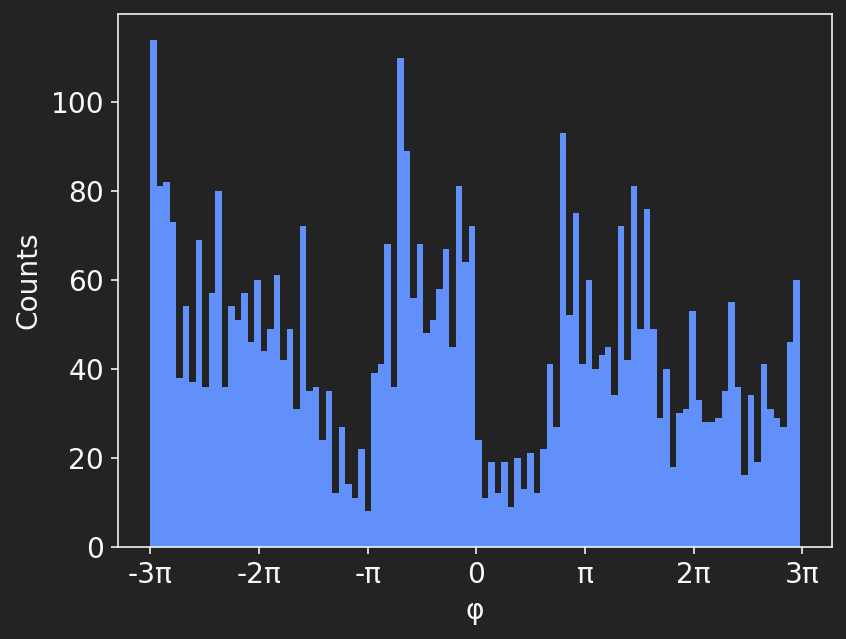

In [25]:
# Plot distribution of values φ where we measured a 0 (i.e., particle hit the screen)

ax = plt.subplot()
plt.hist(φ_hit, bins=100, color='#6190fb')
plt.xticks(ticks=[-3*π, -2*π, -π, 0, π, 2*π, 3*π],
           labels=['-3π','-2π','-π','0','π','2π','3π'],
           fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('φ', fontsize=14)
plt.ylabel('Counts',fontsize=14)
ax.set_axisbelow(True)
plt.show()

In [27]:
z_hit = np.random.uniform(-1,1,len(φ_hit))

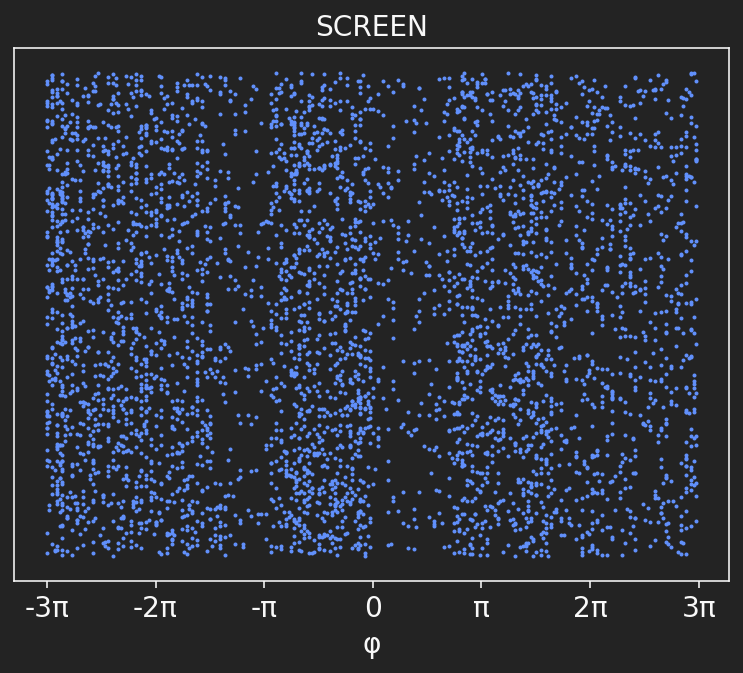

In [28]:
# Emulate hits on a screen. Values of z coordinate are selected at random

plt.scatter(φ_hit,z_hit, s = 1, color='#6190fb')
plt.tick_params(axis='both', left=False, labelleft=False)
plt.xticks(ticks=[-3*π, -2*π, -π, 0, π, 2*π, 3*π],
           labels=['-3π','-2π','-π','0','π','2π','3π'],
           fontsize=14)
plt.xlabel('φ', fontsize=14)
plt.title('SCREEN', fontsize=14)
plt.show()